# Proyecto 2 - Coronavirus

Este proyecto busca estimar el modelo SIR para el Coronavirus.

Liberarias necesarias para la ejecución del notebook.
- Pandas : lectura de datos. 
- Numpy : 
- : generar las gráficas. 

In [5]:
import pandas as pd
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
%matplotlib inline

Liberia para la estimación de parámetros, la información relativa se puede encontrar en: 
- https://github.com/systemsmedicine/PDE_params

In [6]:
import PDEparams as pde

### Ploting raw data

In [11]:
data = pd.read_csv('CoV2019.csv')
days_total = data["Days"]
china_total = data["China"]

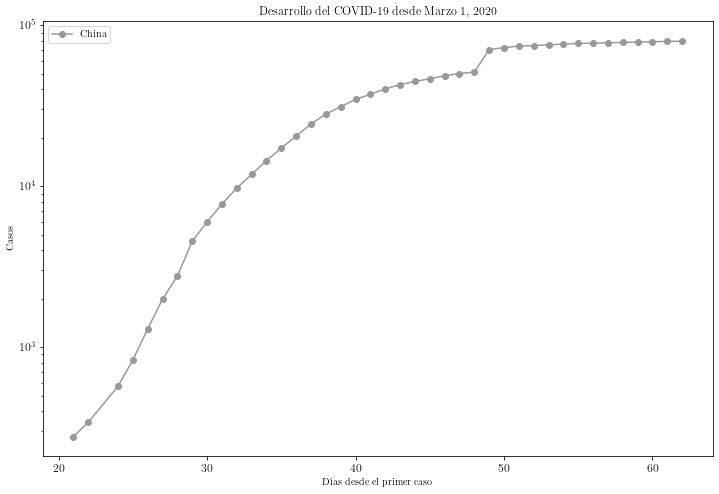

In [12]:
plt.figure(figsize=(12, 8))
plt.title("Desarrollo del COVID-19 desde Marzo 1, 2020")
plt.plot(days_total, china_total, '-o', label="China")
plt.yscale('log')
plt.ylabel("Casos")
plt.xlabel("Días desde el primer caso")
plt.legend()

### Modelo SIR

Se busca estimar el modelo SIR. El modelo original es:

$$\begin{align}
\frac{\mathrm{d} S}{\mathrm{d} t} &= -\beta\, \frac{SI}{N}\\
\frac{\mathrm{d} I}{\mathrm{d} t} &= \beta\, \frac{SI}{N} - \gamma\,I\\
\frac{\mathrm{d} R}{\mathrm{d} t} &= \gamma\,I
\end{align}$$

En donde son las tasas de cambio de susceptibles, infectados y recuperados respectivamente.

$$\begin{align}
\beta &= \text{Contact Rate } \times \text{ Probability of Transmission}\\
\sigma &= \text{Incubation Rate}\\
\gamma &= \text{Recovery Rate}
\end{align}$$

El periodo de incubación del virus varia entre 1 a 14 días, en promedio 5 días.

Sin embargo, se prefiere usar el modelo con los datos normalizados. 

$$\begin{align}
\frac{\mathrm{d} S}{\mathrm{d} t} &= -b \, SI\\
\frac{\mathrm{d} I}{\mathrm{d} t} &= b SI - \gamma\,I\\
\frac{\mathrm{d} R}{\mathrm{d} t} &= \gamma\,I
\end{align}
$$



## Condiciones iniciales

Población total

In [18]:
N = 56*10**4

Condiciones iniciales para el modelo, coínciden con los datos del archivos.

In [19]:
def initial_I():
    return 278/N

def initial_R():
    return 0/N

def initial_S():
    return (N - initial_I() - initial_R())/N

Modelo SIR con normalización

In [20]:
def SIR(y, t, b, g):
    S, I, R = y
    return [-b * S * I, 
            b * S * I - g * I,
            g * I]

Lectura de datos


In [61]:
df = pd.read_csv('CoVC.csv',decimal=",")
df['I']=df['I'].div(N)
infectados = df["I"]
df.head()

,t,I
0,21,0.000496
1,22,0.000609
2,23,0.001020
3,24,0.001482
4,25,0.002316


## Generación del modelo y estimación de los paramétros

In [32]:
lb = 1*10**-10
my_model = pde.PDEmodel(df, SIR, 
                        [initial_S, initial_I, initial_R], 
                        bounds=[(lb,3), (lb,3)], 
                        param_names=[r'$b$', r'$g$'], nvars=3, ndims=0, 
                        nreplicates=1, obsidx=[1], outfunc=None)

In [33]:
# Printing the initial condition
my_model.initial_condition

array([9.99999999e-01, 4.96428571e-04, 0.00000000e+00])

In [34]:
%%time
my_model.fit()

        $b$       $g$
0  0.264794  0.136427
CPU times: user 967 ms, sys: 4.1 ms, total: 971 ms
Wall time: 965 ms


Mejores parámetros obtenidos

In [36]:
my_model.best_params

,$b$,$g$
0,0.264794,0.136427


In [37]:
b, g = my_model.best_params.iloc[0,0],my_model.best_params.iloc[0,1]
b,g

(0.26479367787351216, 0.13642696469863083)

In [38]:
my_model.best_error

4.508173476533432e-05

In [39]:
%%time
my_model.likelihood_profiles()



CPU times: user 40.5 s, sys: 401 ms, total: 40.9 s
Wall time: 40.5 s


In [40]:
my_model.result_profiles

,parameter,value,error
0,$b$,1.000000e-10,0.008035
1,$b$,3.030303e-02,0.008031
2,$b$,6.060606e-02,0.006526
3,$b$,9.090909e-02,0.002431
4,$b$,1.212121e-01,0.000902
...,...,...,...
195,$g$,2.878788e+00,0.008028
196,$g$,2.909091e+00,0.008030
197,$g$,2.939394e+00,0.008034
198,$g$,2.969697e+00,0.008035


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


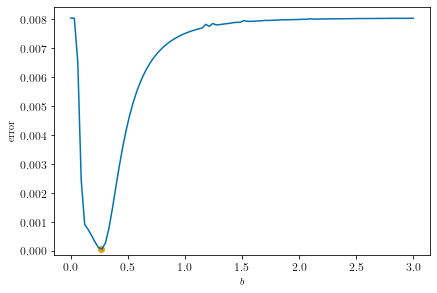

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


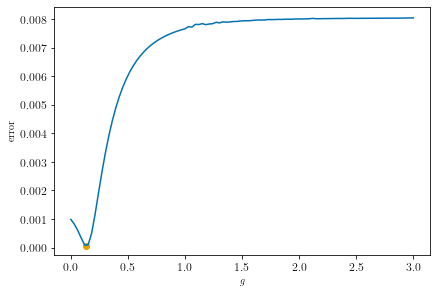

In [41]:
my_model.plot_profiles()

## Verificación de los resultados obtenidos

Se resuelve el sistema de ecuaciones diferenciales usando un vector de tiempo y las condiciones iniciales, para ello se usa Scipy

In [76]:
# Vector de tiempo
t = np.linspace(20, 61, 60)
# Condiciones iniciales del problema
y0 = (N-278)/N,278/N,0

# Se resuelve la ecuación diferencial usando el vector de tiempo t.
ret = odeint(SIR, y0, t, args=(b, g))
S, I, R = ret.T

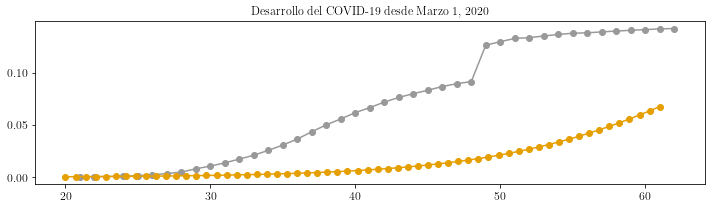

In [77]:
plt.figure(figsize=(12, 3))
plt.title("Desarrollo del COVID-19 desde Marzo 1, 2020")
plt.plot(days_total, infectados, '-o', label="China")
plt.plot(t, I, '-o',label='Infectados')